In [5]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import astropy.table as tab
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
# Load the data and preprocess the labels as shown above
#data_table = tab.Table.read('/content/drive/MyDrive/Colab-Notebooks/workshop_planet_local.fits')
data_table = tab.Table.read('workshop_planet_local.fits')


In [7]:
data_table

id,class,local [201],av_training_set,depth,duration,impact,period,max_mult_ev,model_snr,plnt_num,time0bk,spline_bkspace
int64,bytes3,float64,bytes3,float64,float64,float64,float64,float64,float64,int64,float64,float64
6507433,PC,-0.003685545176267624 .. 0.049602705985307693,PC,3522.0,0.05329166725277901,0.9376999735832214,4.742549896240234,91.80000305175781,106.30000305175781,1,133.13800048828125,0.5
10272640,PC,-0.0009759697713889182 .. -0.003937867935746908,PC,13170.0,0.15862500667572021,0.06650999933481216,3.770550012588501,658.5,639.2999877929688,1,134.656005859375,0.5
9761573,PC,-0.014799775555729866 .. 0.03045441210269928,PC,2207.0,0.11837500333786011,1.0,7.441659927368164,63.369998931884766,59.81999969482422,1,137.3090057373047,0.8952139616012573
10352938,PC,0.0001071926235454157 .. 0.0107777314260602,AFP,6161.0,0.29762500524520874,0.34470000863075256,6.471749782562256,255.3000030517578,260.70001220703125,1,136.3520050048828,0.7372382879257202
6946199,PC,-0.004892205819487572 .. -0.042620230466127396,PC,1350.0,0.23079167306423187,0.29980000853538513,37.101200103759766,48.47999954223633,50.189998626708984,2,147.8730010986328,20.0
10583066,PC,-0.0829419493675232 .. 0.02255663089454174,PC,1896.0,0.06616666913032532,0.3499000072479248,6.029300212860107,54.720001220703125,64.80999755859375,1,135.42799377441406,5.138038635253906
11027624,PC,-0.006467259488999844 .. 0.0021557530853897333,PC,1997.0,1.00041663646698,0.3253999948501587,394.625,76.05999755859375,107.69999694824219,1,177.8459930419922,1.9462679624557495
5640085,PC,0.043257515877485275 .. -0.06920187175273895,PC,1182.0,0.11366666853427887,0.7210999727249146,10.139599800109863,51.7599983215332,56.779998779296875,1,137.89199829101562,0.8952139616012573
2989404,PC,-0.011556240729987621 .. 0.04006163403391838,PC,133.39999389648438,0.09537500143051147,0.5020999908447266,1.678320050239563,53.66999816894531,59.63999938964844,2,132.697998046875,2.3633148670196533


A subset of data taken from Shallue & Vandenburg 2018 (https://ui.adsabs.harvard.edu/abs/2018AJ....155...94S/abstract).

The first step in the 'data preparation' is to phase-fold each light curve using a pipeline that determines the period. Next, a region centered on the transit is selected. The size of this region is a fixed multiple of the transit duration. This region is divided into 201 bins of equal size, and the flux in each bin is then normalized to have a median value of 0 and a maximum depth of -1.


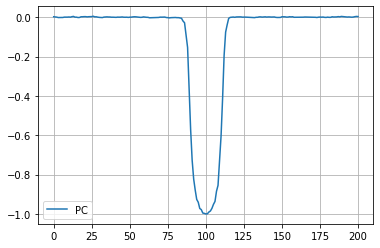

In [40]:
# random example plots
i = 42
plt.plot(data_table['local'][i], label = data_table['class'][i])
plt.legend()
plt.grid()
plt.show()

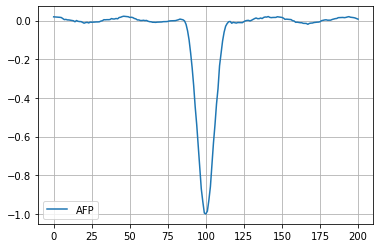

In [38]:
# random example plots
i = 52
plt.plot(data_table['local'][i], label = data_table['class'][i])
plt.legend()
plt.grid()
plt.show()

In [41]:
input_data = np.array(data_table['local'].tolist())

# PC == Planet candidate &  AFP =  Astrophysical False Positives
labels = np.where(data_table['class'] == 'PC', 0, 1)

In [42]:
input_data

array([[-0.00368555,  0.00375317,  0.01159763, ...,  0.03120879,
         0.03120879,  0.04960271],
       [-0.00097597, -0.00297161, -0.00210246, ..., -0.00151494,
        -0.0019131 , -0.00393787],
       [-0.01479978,  0.03045441,  0.03045441, ...,  0.03916331,
         0.03045441,  0.03045441],
       ...,
       [ 0.00931278,  0.00620852,  0.00299722, ...,  0.00085635,
        -0.00042817,  0.00064226],
       [ 0.00467737,  0.00580445,  0.00580445, ..., -0.00636799,
        -0.00636799,  0.00383207],
       [ 0.00093969, -0.00484948, -0.00481592, ..., -0.00761822,
        -0.00605766, -0.00625902]])

In [43]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [44]:
# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.2, random_state=1)


In [45]:
X_train


array([[-5.01807663e-05, -5.01807663e-05,  6.55957706e-07, ...,
         1.00033554e-04,  2.71238503e-04,  6.06760877e-05],
       [-1.13098860e-01, -8.08794573e-02, -3.87133695e-02, ...,
         5.19875474e-02,  7.33478833e-03,  1.04118213e-02],
       [-2.53590348e-04, -4.80947201e-04, -4.80947201e-04, ...,
         6.24648388e-03,  3.99623392e-03,  3.44241597e-03],
       ...,
       [-1.41637493e-02, -1.19244326e-02, -9.86707956e-03, ...,
        -4.59602801e-03, -4.74570692e-03, -1.30308839e-03],
       [ 1.63372327e-02, -4.73981444e-03, -1.31101254e-03, ...,
         4.84066177e-03, -2.74808388e-02, -2.23376360e-02],
       [ 1.04430383e-02, -1.01265823e-02,  2.84810131e-03, ...,
        -1.39240511e-02,  5.56962043e-02,  5.00000007e-02]])

In [46]:
# Reshape the input data to match the input shape expected by the CNN
X_train = X_train.reshape(-1, 201, 1)
X_test = X_test.reshape(-1, 201, 1)

In [47]:
X_train.shape

(800, 201, 1)

In [48]:
X_train

array([[[-5.01807663e-05],
        [-5.01807663e-05],
        [ 6.55957706e-07],
        ...,
        [ 1.00033554e-04],
        [ 2.71238503e-04],
        [ 6.06760877e-05]],

       [[-1.13098860e-01],
        [-8.08794573e-02],
        [-3.87133695e-02],
        ...,
        [ 5.19875474e-02],
        [ 7.33478833e-03],
        [ 1.04118213e-02]],

       [[-2.53590348e-04],
        [-4.80947201e-04],
        [-4.80947201e-04],
        ...,
        [ 6.24648388e-03],
        [ 3.99623392e-03],
        [ 3.44241597e-03]],

       ...,

       [[-1.41637493e-02],
        [-1.19244326e-02],
        [-9.86707956e-03],
        ...,
        [-4.59602801e-03],
        [-4.74570692e-03],
        [-1.30308839e-03]],

       [[ 1.63372327e-02],
        [-4.73981444e-03],
        [-1.31101254e-03],
        ...,
        [ 4.84066177e-03],
        [-2.74808388e-02],
        [-2.23376360e-02]],

       [[ 1.04430383e-02],
        [-1.01265823e-02],
        [ 2.84810131e-03],
        ...,
        

Typical structure of CNN :

In [49]:
# Define the CNN architecture
model = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=16, activation='relu', input_shape=(201, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [37]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test))


Epoch 1/50
8/8 [==============================] - 1s 58ms/step - loss: 0.6652 - accuracy: 0.5975 - val_loss: 0.6146 - val_accuracy: 0.7950
Epoch 2/50
8/8 [==============================] - 0s 33ms/step - loss: 0.5798 - accuracy: 0.8000 - val_loss: 0.5135 - val_accuracy: 0.8350
Epoch 3/50
8/8 [==============================] - 0s 37ms/step - loss: 0.4879 - accuracy: 0.8175 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 4/50
8/8 [==============================] - 0s 38ms/step - loss: 0.4084 - accuracy: 0.8512 - val_loss: 0.3866 - val_accuracy: 0.8300
Epoch 5/50
8/8 [==============================] - 0s 41ms/step - loss: 0.3736 - accuracy: 0.8462 - val_loss: 0.3770 - val_accuracy: 0.8350
Epoch 6/50
8/8 [==============================] - 0s 36ms/step - loss: 0.3542 - accuracy: 0.8525 - val_loss: 0.3782 - val_accuracy: 0.8600
Epoch 7/50
8/8 [==============================] - 0s 38ms/step - loss: 0.3463 - accuracy: 0.8625 - val_loss: 0.3853 - val_accuracy: 0.8750
Epoch 8/50
8/8 [===========

In [38]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

7/7 [==============================] - 0s 5ms/step - loss: 0.7179 - accuracy: 0.8400
Test accuracy: 0.8399999737739563


7/7 [==============================] - 0s 8ms/step - loss: 0.7179 - accuracy: 0.8400
Test accuracy: 0.8399999737739563
7/7 [==============================] - 0s 6ms/step
Confusion matrix:
[[79 20]
 [12 89]]


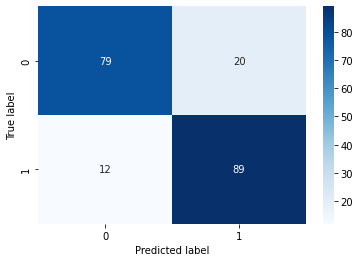

In [39]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

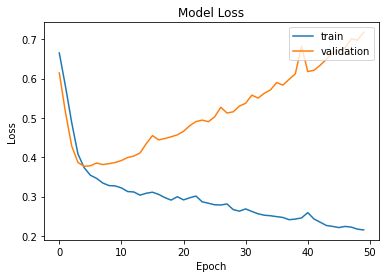

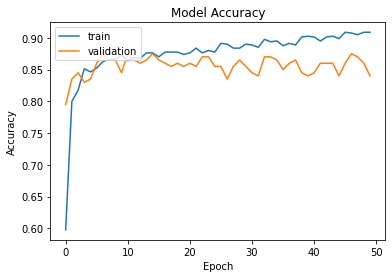

In [40]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
25/25 [==============================] - 2s 36ms/step - loss: 0.6231 - accuracy: 0.7675 - val_loss: 0.5631 - val_accuracy: 0.8150
Epoch 2/10
25/25 [==============================] - 1s 25ms/step - loss: 0.4584 - accuracy: 0.8400 - val_loss: 0.4334 - val_accuracy: 0.8100
Epoch 3/10
25/25 [==============================] - 1s 24ms/step - loss: 0.3643 - accuracy: 0.8512 - val_loss: 0.4132 - val_accuracy: 0.8300
Epoch 4/10
25/25 [==============================] - 1s 25ms/step - loss: 0.3446 - accuracy: 0.8625 - val_loss: 0.4428 - val_accuracy: 0.8000
Epoch 5/10
25/25 [==============================] - 1s 25ms/step - loss: 0.3343 - accuracy: 0.8700 - val_loss: 0.4048 - val_accuracy: 0.8400
Epoch 6/10
25/25 [==============================] - 1s 23ms/step - loss: 0.3445 - accuracy: 0.8700 - val_loss: 0.4199 - val_accuracy: 0.8350
Epoch 7/10
25/25 [==============================] - 1s 24ms/step - loss: 0.3217 - accuracy: 0.8737 - val_loss: 0.4245 - val_accuracy: 0.8400
Epoch 8/10
25

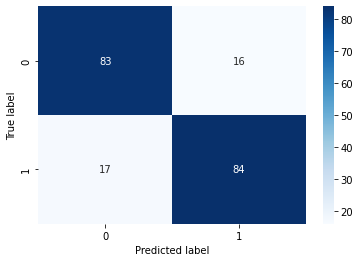

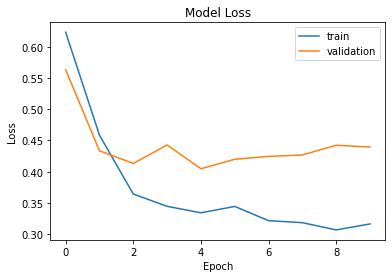

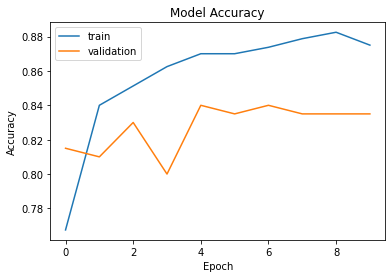

In [16]:
# Define the CNN architecture
model = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(201, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# define the checkpoint filepath
checkpoint_filepath = 'model_weights_{epoch:02d}.h5'

# define the ModelCheckpoint callback to save the weights
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, save_freq='epoch')

# train the model using the checkpoint callback
model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/40
25/25 [==============================] - 2s 30ms/step - loss: 0.5888 - accuracy: 0.7500 - val_loss: 0.5019 - val_accuracy: 0.7900
Epoch 2/40
25/25 [==============================] - 0s 19ms/step - loss: 0.3979 - accuracy: 0.8450 - val_loss: 0.4201 - val_accuracy: 0.8100
Epoch 3/40
25/25 [==============================] - 0s 19ms/step - loss: 0.3498 - accuracy: 0.8612 - val_loss: 0.4175 - val_accuracy: 0.8200
Epoch 4/40
25/25 [==============================] - 0s 19ms/step - loss: 0.3507 - accuracy: 0.8712 - val_loss: 0.4452 - val_accuracy: 0.8100
Epoch 5/40
24/25 [===========================>..] - ETA: 0s - loss: 0.3238 - accuracy: 0.8737

KeyboardInterrupt: ignored

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [61]:
# assume that `model` is your trained CNN model
model.save('model_architecture.h5')

In [65]:
from tensorflow.keras.models import load_model

# Load the model architecture
model = load_model('model_architecture.h5')

# Load the weights at epoch 20
model.load_weights('model_weights_20.h5')

SyntaxError: ignored

7/7 [==============================] - 0s 5ms/step - loss: 0.5277 - accuracy: 0.8300
Test accuracy: 0.8299999833106995
7/7 [==============================] - 0s 4ms/step
Confusion matrix:
[[81 18]
 [16 85]]


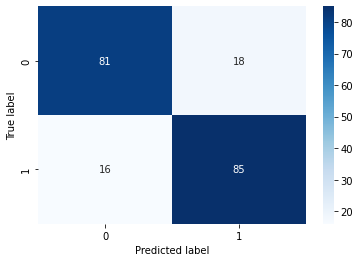

In [68]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [55]:
model.load_weights?


In [63]:
import os
print(os.getcwd())


/content


In [ ]:
/content/model_weights_12.h5

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a function that returns the compiled model
def create_model(filters=64, kernel_size=4, units=32):
    model = keras.Sequential([
        keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(201, 1)),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=units, activation='relu'),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier using your model function
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameter grid to search over
param_grid = {'filters': [32, 64, 128], 'kernel_size': [3, 4, 5], 'units': [16, 32, 64]}

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and the corresponding mean test score
print('Best parameters:', grid_result.best_params_)
print('Best test score:', grid_result.best_score_)

<ipython-input-17-0b5ac6ffc241>:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


KeyboardInterrupt: ignored

In [43]:
from tensorflow import keras                                                                                                                                         
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout                                                                                    
from tensorflow.keras.optimizers import Adam                                                                                                                         
from tensorflow.keras.callbacks import EarlyStopping 

# Define the CNN architecture                                                                                                                                        
model = keras.Sequential([                                                                                                                                           
    Conv1D(filters=32, kernel_size=8, activation='relu', input_shape=(201, 1)),                                          
    MaxPooling1D(pool_size=8),                                                                                                                                       
    Dropout(0.1),                                                                                                                                                    
    Conv1D(filters=64, kernel_size=4, activation='relu'),                                                                
    MaxPooling1D(pool_size=4),                                                                                             
    Dropout(0.15),                                                                                                         
    Conv1D(filters=128, kernel_size=3, activation='relu'),                     
    MaxPooling1D(pool_size=2),                                                                                             
    Dropout(0.25),                                                                                                         
    Flatten(),                                                                                                             
    Dense(units=128, activation='relu'),                                        
    Dropout(0.25),                                                                                                         
    Dense(units=64, activation='relu'),                                                                                    
    Dropout(0.15),                                                                                                         
    Dense(units=32, activation='relu'),                                                                                    
    Dropout(0.1),                                                                                                          
    Dense(units=16, activation='relu'),                                                                                    
    Dense(units=1, activation='sigmoid')                                                                                   
])                                                                                                                         
# Set the learning rate                                                                                                    
lr = 0.0001                                                                                                                
# Compile the model with a custom optimizer                                                                                
optimizer = Adam(learning_rate=lr)                                                                                         
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])                                       
# Set up early stopping                                                                                                    
early_stop = EarlyStopping(monitor='val_loss', patience=45)                                                                
# Train the model                                                                                                          
history = model.fit(X_train, y_train, epochs=1000, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stop])
# Evaluate the model on the test set                     
test_loss, test_acc = model.evaluate(X_test, y_test)     
print('Test accuracy:', test_acc)                                                     
# Make predictions on the test set                       
test_predictions = model.predict(X_test)                                                                                 
# Convert the predictions to binary labels (0 or 1)      
test_predictions = np.round(test_predictions).astype(int)
# Create a confusion matrix                           
cm = confusion_matrix(y_test, test_predictions)       

Epoch 1/1000
80/80 [==============================] - 3s 9ms/step - loss: 0.6933 - accuracy: 0.4875 - val_loss: 0.6929 - val_accuracy: 0.5100
Epoch 2/1000
80/80 [==============================] - 1s 8ms/step - loss: 0.6925 - accuracy: 0.5225 - val_loss: 0.6913 - val_accuracy: 0.7950
Epoch 3/1000
80/80 [==============================] - 1s 8ms/step - loss: 0.6917 - accuracy: 0.5337 - val_loss: 0.6894 - val_accuracy: 0.5300
Epoch 4/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.6892 - accuracy: 0.5713 - val_loss: 0.6856 - val_accuracy: 0.7050
Epoch 5/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.6852 - accuracy: 0.6087 - val_loss: 0.6731 - val_accuracy: 0.8000
Epoch 6/1000
80/80 [==============================] - 1s 8ms/step - loss: 0.6694 - accuracy: 0.6662 - val_loss: 0.6325 - val_accuracy: 0.7550
Epoch 7/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.6221 - accuracy: 0.7375 - val_loss: 0.5096 - val_accuracy: 0.8350
Epoch 

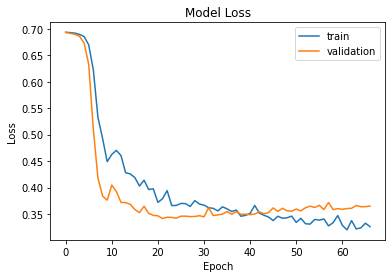

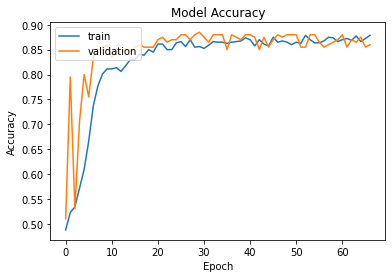

In [44]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

7/7 [==============================] - 0s 7ms/step - loss: 0.3650 - accuracy: 0.8600
Test accuracy: 0.8600000143051147
7/7 [==============================] - 0s 6ms/step
Confusion matrix:
[[80 19]
 [ 9 92]]


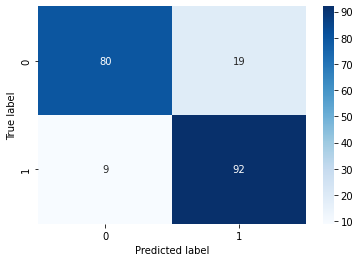

In [45]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()